In [4]:
# Libraries imports

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import kagglehub
from kagglehub import KaggleDatasetAdapter


from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBClassifier


from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


In [5]:
# 1. Import of the personality dataframe

df = pd.read_csv('personality_dataset.csv')
df.head()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [6]:
# 2. First of all, I shorten column names, for convenience, after looking for their definitions here:
# https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data

df = df.rename(columns=
    {'Time_spent_Alone' : 'alone_hours',
     'Stage_fear' : 'stage_fear',
     'Social_event_attendance' : 'socevent_freq',
     'Going_outside' : 'outside_freq',
     'Drained_after_socializing' : 'social_drain',
     'Friends_circle_size' : 'clfriends',
     'Post_frequency' : 'post_freq',
     'Personality' : 'personality'
    }
)
    
    
df.head()

,alone_hours,stage_fear,socevent_freq,outside_freq,social_drain,clfriends,post_freq,personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [7]:
# 2. A few checks on the dataframe status.

# The dataframe consists of 2900 rows, but some values are missing

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   alone_hours    2837 non-null   float64
 1   stage_fear     2827 non-null   object 
 2   socevent_freq  2838 non-null   float64
 3   outside_freq   2834 non-null   float64
 4   social_drain   2848 non-null   object 
 5   clfriends      2823 non-null   float64
 6   post_freq      2835 non-null   float64
 7   personality    2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [8]:
# I'll fill-in the values after a train-test split

df.isna().sum()

alone_hours      63
stage_fear       73
socevent_freq    62
outside_freq     66
social_drain     52
clfriends        77
post_freq        65
personality       0
dtype: int64

In [9]:
# Since the share of rows with missing values is minuscule, I decide to drop them

df = df.dropna()

df.shape

(2477, 8)

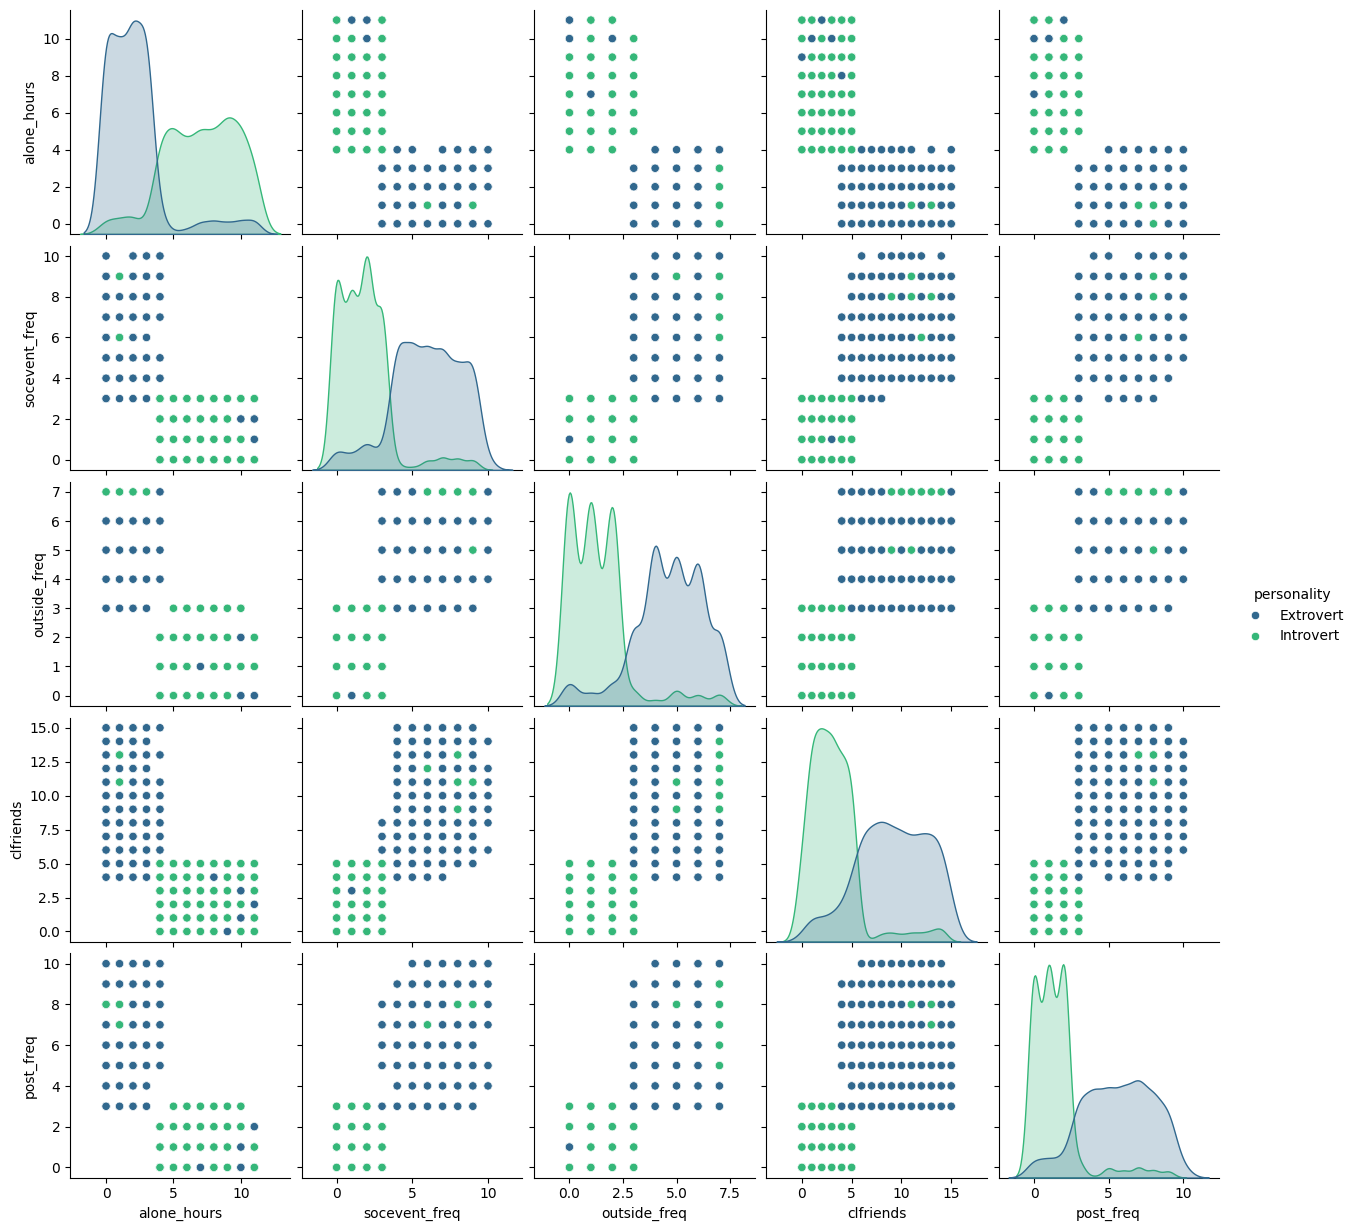

In [10]:
# 3. I create a pairplot, just to observe relations between variables

# average extroverts seem to participate more frequently to social events, go out more often, have a broader circle of close friends and post more frequently, while passing less time alone
# Some of the numeric features might be highly correlated, I have to verify this


sns.pairplot(df, 
             diag_kind = 'kde', 
             hue = 'personality',
             palette = 'viridis');

<Axes: >

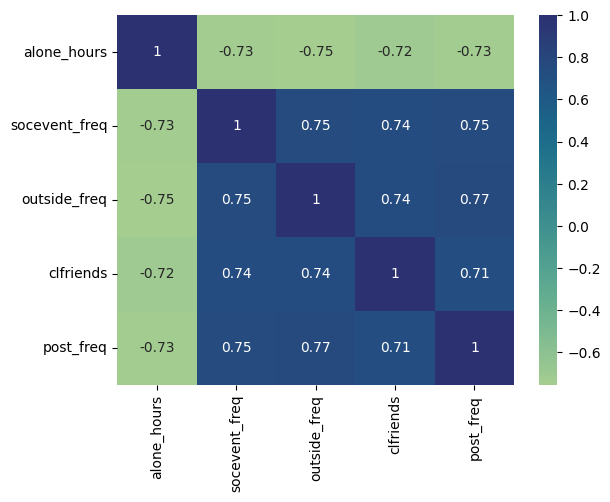

In [11]:
# I notice that the correlation between variables is extremely high: this could cause a problem to the performance of my model. 
# I will keep all the features for now, but will try to remove some to try and see if my model performs better.

sns.heatmap(df.select_dtypes(include='number').corr(),
            cmap='crest',
            annot = True
)            

In [12]:
# 4. Let's separate X and y

X = df.drop(columns=['personality'])
y = df['personality']


In [13]:
# Let's create train and test dataframes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)


In [14]:
# 5. In the original dataframe the columns "stage_fear" and "social_drain" need to be converted into numbers

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2477 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   alone_hours    2477 non-null   float64
 1   stage_fear     2477 non-null   object 
 2   socevent_freq  2477 non-null   float64
 3   outside_freq   2477 non-null   float64
 4   social_drain   2477 non-null   object 
 5   clfriends      2477 non-null   float64
 6   post_freq      2477 non-null   float64
 7   personality    2477 non-null   object 
dtypes: float64(5), object(3)
memory usage: 174.2+ KB


In [15]:
ohe = OneHotEncoder(dtype = 'int',
                    drop = 'first',
                    feature_name_combiner = 'concat')

ct = ColumnTransformer(transformers = 
    [
    ('ohe', ohe, ['stage_fear', 'social_drain'])
    ],
     remainder = 'passthrough'
     )

In [16]:
ct.fit(X_train)

X_train_transf = ct.transform(X_train)
X_test_transf = ct.transform(X_test)

In [17]:
# 6. Now I try to do some predictions with models

models_dict = {
    'knc3' : KNeighborsClassifier(n_neighbors = 3),
    'knc5' : KNeighborsClassifier(n_neighbors = 5),
    'knc7' : KNeighborsClassifier(n_neighbors = 7),
    'knc9' : KNeighborsClassifier(n_neighbors = 9),
    'knc11' : KNeighborsClassifier(n_neighbors = 11),
    'knc13' : KNeighborsClassifier(n_neighbors = 13),
    'dtrc' : DecisionTreeClassifier(),
    'logreg': LogisticRegression(),
    'logregCV': LogisticRegressionCV(),
    'rfoc' : RandomForestClassifier(n_estimators = 1000)
    }

scores_df = pd.DataFrame(columns = ['accuracy_test', 'accuracy_train', 'precision_test', 'precision_train','recall_test', 'recall_train','f1_score_test','f1_score_train'])

scores_df

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_score_test,f1_score_train


In [18]:
for k, v in models_dict.items():
    v.fit(X_train_transf, y_train)
    y_train_preds = v.predict(X_train_transf)
    y_test_preds = v.predict(X_test_transf)
    
    scores_df.loc[k, 'precision_test'] = np.round(precision_score(y_test, y_test_preds, pos_label='Introvert'), 3)
    scores_df.loc[k, 'accuracy_test'] = np.round(accuracy_score(y_test, y_test_preds), 3)
    scores_df.loc[k, 'recall_test'] = np.round(recall_score(y_test, y_test_preds, pos_label='Introvert'), 3)
    scores_df.loc[k, 'f1_score_test'] = np.round(f1_score(y_test, y_test_preds, pos_label='Introvert'), 3)
    
    scores_df.loc[k, 'precision_train'] = np.round(precision_score(y_train, y_train_preds, pos_label='Introvert'), 3)
    scores_df.loc[k, 'accuracy_train'] = np.round(accuracy_score(y_train, y_train_preds), 3)
    scores_df.loc[k, 'recall_train'] = np.round(recall_score(y_train, y_train_preds, pos_label='Introvert'), 3)
    scores_df.loc[k, 'f1_score_train'] = np.round(f1_score(y_train, y_train_preds, pos_label='Introvert'), 3)


scores_df

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_score_test,f1_score_train
knc3,0.897,0.941,0.882,0.93,0.911,0.949,0.896,0.939
knc5,0.905,0.934,0.896,0.923,0.911,0.943,0.904,0.933
knc7,0.911,0.931,0.895,0.92,0.928,0.939,0.911,0.93
knc9,0.913,0.932,0.898,0.92,0.928,0.941,0.913,0.93
knc11,0.916,0.929,0.901,0.917,0.931,0.938,0.916,0.927
knc13,0.915,0.929,0.901,0.917,0.928,0.939,0.914,0.928
dtrc,0.826,0.983,0.838,0.989,0.799,0.976,0.818,0.982
logreg,0.916,0.928,0.901,0.915,0.931,0.939,0.916,0.927
logregCV,0.916,0.928,0.901,0.915,0.931,0.939,0.916,0.927
rfoc,0.902,0.983,0.891,0.971,0.911,0.994,0.901,0.982
